# Fantasy Football Project

In this project we will leverage the FFP API to gain access to player and team data to enable more infomred managerial decisions. 

Ultimate end goal would be to host an app that takes in a players current team and makes suggestions for best transfers to make backed up by evidence!! We also want to incorporate a machine learning element. 


Key Link:\
https://medium.com/@frenzelts/fantasy-premier-league-api-endpoints-a-detailed-guide-acbd5598eb19#:~:text=The%20answer%20is%20simple.,before%20the%20'%2Fhistory'.

Notes / Brainstorm. 

Before we start it would be good to have some idea as to how we want to end. Here are some ideas: /
1. We want to take historical player data to inform how they might perform in the next 1, 3 and 5 games
2. We want to state the team that could have been selected at the beginning of the season and left and scored the highest points up to the current date
3. We want to state the team that would have produced the best score utilizing weekly transfers, within the rules of the game to have the absoulte best score at the current date.
2. Features that we're interested in are 
 * ICT data, 
 * FDR, 
 * performance against top clubs, 
 * previous points, 
 * average points / recent average 
 * performs both home and away?, 
 * likelihood to play 90mins, cost, 
 * expected points per unit cost
 * Team form
 * In the news
 * Player analysis... injury prone, playing out of position, blows hot and cold, press sentiment
 * Double gameweeks?
 * Age
 * Previous season statistics
3. Target features
 * Simply make a points prediction for each of the next three matches
 * Make an average points per game prediction for next 1, 3, 5 games
4. Recommendations to take into account
 * Number of free transfers
 * Poorly performing players in current squad
 * Best cost to points ratio
 * Pick three teams of the players expected to perform the best in the next three games. This leaves the manager to decide which player/s they want to transfer in /out
 * Recommend the top one / two (affordable) players that have the highest expected points in the next three games. This should be an aggregate score agains the expected points of the players being removed. 
 * Recommend teh one / twom players to be transferred out of the squad based on the players in recommendation.
 * The recommendation engine should have the ability to issue "Wait" advice if there are no transfers that will improve the squad with the requisite level of confidence.
 * Cold start problem - selecting the initial squad
 * Player predicted to be the highest scoring in next gameweek (recommend captain)


**Problems / Challenges:**
1. We initially wanted to treat this as a typical time series problem. We'd input historical feature values in an attempt to predict near/mid term future performance. The problem is that our dataset is split into gameweeks of which there are only 38 in a season and then split per player (n~650). So we have 650 parallel time series problems of maximum length 38. That's not much data at all. If we had this much detail over, say, 20 seasons you might be able to gleen some insight but even then the data set would be small.
2. One solution is to treat all player gameweeks (n>17000 at gw 26 rising to n~26000 at gw 38) as a single linear time series data set. This would present a difficult code challenge for the followig reasons:
    * We can't use one players history to predict another players future, we'd need to intervene at the crossover.
    * We would have to ask the model to skip the most recent player history (dependent on how many future gameweeks         we're wanting to predict) and jump to the next player.
    * Varying the length of input steps is limited as again we only have a max of 38 gameweeks. 
    * This solution, with this little data is not a viable option. 
3. We have to take into account that the players themselves are different (different positions, different ages, different characteristics) Is it sensible to lump them all into one linear relationship or time series? 
4. Some players score big at the beginning of a season then tail off, some the opposite, some score in bursts of a few games but then go quiet, some score randomly, some only score at home, some vice versa
5. Furthermore how would you split the data for train/test... would each player have a train and test set or would you treat the set as a single player and just select the last 25% of data points as test set? There would clearly be pros and cons to each method.
6. What to do about players who drop a gameweek... this could severely skew the results. If a player has played two of the past three games and we're using the average score from the past three games. How to solve that?
7. It's inevitable that their will have to be some manager manual intervention as a final say on whether a player is subbed in or not. 
8. Different positions score points differently, defenders get 4 points for a clean sheet - attackers get none. How will our model learn when some players score points for some things when others don't. We may need to model the positions separately - intuition also says that this is a sensible approach. Unless some kind of balancing feature can be employed that acts as a kind of coefficient of multiple features?! PCA?

9. An extensive EDA is required to understand how players score and what drives either low or high scoring. Then we can best understand which models to employ. 
10. We want to discern signal from noise!!

### The Plan
1. Initially we'll look into a simple linear regression problem that can be solved via using Sklearn's linear regression packages, random forest regressors and deep learning regressors with neural networks.
2. Secondly we'll review whether an LSTM can be utilised.

In this notebook we will interact with the api to see what kind of information we can access.

In [1114]:
# import libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

In [1115]:
import warnings
warnings.filterwarnings("ignore")

In [1116]:
plt.style.use("fivethirtyeight")

In [1117]:
# Allow notebokk to see all columns in a df
pd.set_option('display.max_columns', None)

In [1213]:
# Set our fantasy football api endpoint
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
player = "https://fantasy.premierleague.com/api/element-summary/4/"
manager = "https://fantasy.premierleague.com/api/entry/801047/history/" # 801047 id of current top manager

In [1214]:
# Create a response object
r = requests.get(url)
p = requests.get(player)
m = requests.get(manager)

In [1215]:
type(r)

requests.models.Response

In [1216]:
type(p)

requests.models.Response

In [1217]:
# Let's transform the response body into a JSON object
json = r.json()
player_json = p.json()
manager_json = m.json()

In [1218]:
# What keys have we access to with the json?
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [1219]:
player_json.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [1220]:
manager_json.keys()

dict_keys(['current', 'past', 'chips'])

In [1125]:
# Create a dataframe of all the players' current stats
elements_df = pd.DataFrame(json['elements'])

In [1126]:
print(elements_df.shape)
elements_df.head(3)

(686, 67)


,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0.0,0.0,37605,0,0,-3,3,0,3,0.0,0.0,0,Mesut,0.0,1,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-20T22:30:18.118477Z,67,37605.jpg,0.0,Özil,0.5,False,None,u,1,3,0,3441,0,54604,37,0.0,0.0,Özil,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,686,278,686,278,686,278,686,278,NaN,,NaN,,NaN,
1,0.0,0.0,39476,0,0,-2,2,0,2,0.0,0.0,0,Sokratis,0.0,2,False,Left the club by mutual consent on 20/1,2020-10-21T10:30:18.546407Z,48,39476.jpg,0.0,Papastathopoulos,0.1,False,None,u,1,3,0,10266,0,19103,8,0.0,0.0,Sokratis,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,649,232,641,233,633,230,652,232,NaN,,NaN,,NaN,
2,100.0,100.0,41270,0,0,-1,1,0,2,3.2,3.2,2,David,3.2,3,False,,2021-02-02T20:30:22.388696Z,54,41270.jpg,2.2,Luiz Moreira Marinho,1.0,False,None,a,1,3,39,69816,7362,110632,1251,0.6,7.2,David Luiz,1254,1,0,3,17,0,0,0,1,1,0,0,206,224.6,44.2,113.0,37.9,228,91,323,104,225,62,285,94,NaN,,4.0,,NaN,


In [1127]:
elements_df.total_points.describe() # Mean = 33

count    686.000000
mean      34.667638
std       39.185321
min       -3.000000
25%        0.000000
50%       20.000000
75%       58.000000
max      209.000000
Name: total_points, dtype: float64

In [1128]:
# Check difference between second name and web name
print(elements_df.second_name.nunique(), elements_df.web_name.nunique())

644 648


In [1129]:
teams = pd.DataFrame(json["teams"])

In [1130]:
print(teams.shape)
teams.head()

(20, 21)


,code,draw,form,id,loss,name,played,points,position,short_name,strength,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,4,None,False,0,1190,1210,1170,1210,1190,1200,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,3,None,False,0,1150,1150,1150,1150,1180,1210,2
2,36,0,None,3,0,Brighton,0,0,0,BHA,3,None,False,0,1120,1100,1150,1180,1090,1100,131
3,90,0,None,4,0,Burnley,0,0,0,BUR,3,None,False,0,1070,1080,1120,1190,1010,1030,43
4,8,0,None,5,0,Chelsea,0,0,0,CHE,4,None,False,0,1250,1300,1240,1280,1270,1310,4


In [1131]:
team = teams[["id", "name", "short_name"]]

In [1132]:
print(team.shape)
team.head()

(20, 3)


,id,name,short_name
0,1,Arsenal,ARS
1,2,Aston Villa,AVL
2,3,Brighton,BHA
3,4,Burnley,BUR
4,5,Chelsea,CHE


In [1133]:
# Create a dataframe of basic player details
player_basic = elements_df[["element_type", "id", 
                            "team", "web_name", 
                            "first_name", "second_name", "code"]].merge(team, how="left", 
                                                                        left_on="team", 
                                                                        right_on="id").drop("id_y", axis=1)



player_basic.rename(columns={"id_x": "id",
                             "name": "team"}, inplace=True)
#info = value_set.merge(names, how="left", left_on="element", right_on="id").drop("id", axis=1)

In [1134]:
print(player_basic.shape)
player_basic.head(4)

(686, 9)


,element_type,id,team,web_name,first_name,second_name,code,team,short_name
0,3,1,1,Özil,Mesut,Özil,37605,Arsenal,ARS
1,2,2,1,Sokratis,Sokratis,Papastathopoulos,39476,Arsenal,ARS
2,2,3,1,David Luiz,David,Luiz Moreira Marinho,41270,Arsenal,ARS
3,3,4,1,Aubameyang,Pierre-Emerick,Aubameyang,54694,Arsenal,ARS


In [1135]:
# Send the basic player information to a new dataset .csv
player_basic.to_csv("basic_player_info.csv", index=False)

## Create master dataset

Create a table of all to date player data for current season, 
1. Initiate a master dataset based on player id #1
1. we'll loop through all others player id's
2. use the current id to call in the player history
3. Add that to the master dataset


In [1136]:
player1 = "https://fantasy.premierleague.com/api/element-summary/1/"
p1 = requests.get(player1)
type(p1)
player1_json = p1.json()
plr1_hist = pd.DataFrame(player1_json['history'])

In [1137]:
plr1_hist.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840


In [1138]:
data = plr1_hist
for i in range(2, elements_df.shape[0]):
    # Access the endpoint
    player = f"https://fantasy.premierleague.com/api/element-summary/{i}/"
    # Store data as json
    get_player = requests.get(player)
    player_json = get_player.json()
    # Convert the player history in a dataframe
    player_hist = pd.DataFrame(player_json['history'])
    # Add the player history to the master player history dataset
    data = data.append(player_hist)

In [1139]:
data.shape

(17799, 31)

In [1140]:
data[data.element==1]
data.tail()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
1,683,276,14,0,False,2021-03-12T20:00:00Z,1,1,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,18,34,21,3
0,684,260,3,0,False,2021-03-06T20:00:00Z,1,2,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,0,0,0,0
1,684,274,15,0,True,2021-03-14T14:00:00Z,5,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,27,42,35,8
0,685,268,19,0,False,2021-03-08T20:00:00Z,2,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0
1,685,273,5,0,True,2021-03-13T12:30:00Z,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,59,99,68,9


In [1141]:
data

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,683,276,14,0,False,2021-03-12T20:00:00Z,1,1,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,18,34,21,3
0,684,260,3,0,False,2021-03-06T20:00:00Z,1,2,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,0,0,0,0
1,684,274,15,0,True,2021-03-14T14:00:00Z,5,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,27,42,35,8
0,685,268,19,0,False,2021-03-08T20:00:00Z,2,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0


In [1142]:
data.columns

Index(['element', 'fixture', 'opponent_team', 'total_points', 'was_home',
       'kickoff_time', 'team_h_score', 'team_a_score', 'round', 'minutes',
       'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'value', 'transfers_balance', 'selected',
       'transfers_in', 'transfers_out'],
      dtype='object')

In [1143]:
# Export this base dataset to csv
data.to_csv("players.csv", index=False)

In [1144]:
data_grouped = data.groupby("element")

In [1145]:
player_stats = data_grouped.describe()

In [1146]:
player_stats.head()

fixture                                                          \
          count        mean        std  min    25%    50%    75%    max   
element                                                                   
1          28.0  136.142857  82.165467  2.0  67.75  136.0  203.0  269.0   
2          28.0  136.142857  82.165467  2.0  67.75  136.0  203.0  269.0   
3          28.0  136.142857  82.165467  2.0  67.75  136.0  203.0  269.0   
4          28.0  136.142857  82.165467  2.0  67.75  136.0  203.0  269.0   
5          28.0  136.142857  82.165467  2.0  67.75  136.0  203.0  269.0   

        opponent_team                                                    \
                count       mean       std  min   25%   50%   75%   max   
element                                                                   
1                28.0  11.142857  5.615549  2.0  6.75  11.5  16.0  20.0   
2                28.0  11.142857  5.615549  2.0  6.75  11.5  16.0  20.0   
3                28.0  11.142857  5.615549  2.0  6.75  11.5  16.0  20.0   
4                28.0  11.142857  5.615549  2.0  6.75  11.5  16.0  20.0   
5                28.0  11.142857  5.615549  2.0  6.75  11.5  16.0  20.0   

        total_points                                                \
               count      mean       std  min  25%  50%  75%   max   
element                                                              
1               28.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0   
2               28.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0   
3               28.0  1.392857  2.298780 -3.0  0.0  1.0  2.0   8.0   
4               28.0  3.714286  4.759841  0.0  1.0  2.0  3.5  20.0   
5               28.0  1.000000  2.434322  0.0  0.0  0.0  1.0  12.0   

        team_h_score                                               \
               count      mean       std  min  25%  50%  75%  max   
element                                                             
1               28.0  1.142857  1.177388  0.0  0.0  1.0  2.0  4.0   
2               28.0  1.142857  1.177388  0.0  0.0  1.0  2.0  4.0   
3               28.0  1.142857  1.177388  0.0  0.0  1.0  2.0  4.0   
4               28.0  1.142857  1.177388  0.0  0.0  1.0  2.0  4.0   
5               28.0  1.142857  1.177388  0.0  0.0  1.0  2.0  4.0   

        team_a_score                                                round  \
               count      mean       std  min   25%  50%   75%  max count   
element                                                                     
1               28.0  1.214286  1.100745  0.0  0.75  1.0  1.25  4.0  28.0   
2               28.0  1.214286  1.100745  0.0  0.75  1.0  1.25  4.0  28.0   
3               28.0  1.214286  1.100745  0.0  0.75  1.0  1.25  4.0  28.0   
4               28.0  1.214286  1.100745  0.0  0.75  1.0  1.25  4.0  28.0   
5               28.0  1.214286  1.100745  0.0  0.75  1.0  1.25  4.0  28.0   

                                                      minutes             \
         mean       std  min   25%   50%    75%   max   count       mean   
element                                                                    
1        14.5  8.225975  1.0  7.75  14.5  21.25  28.0    28.0   0.000000   
2        14.5  8.225975  1.0  7.75  14.5  21.25  28.0    28.0   0.000000   
3        14.5  8.225975  1.0  7.75  14.5  21.25  28.0    28.0  44.785714   
4        14.5  8.225975  1.0  7.75  14.5  21.25  28.0    28.0  66.107143   
5        14.5  8.225975  1.0  7.75  14.5  21.25  28.0    28.0  24.964286   

                                                goals_scored            \
               std  min   25%   50%   75%   max        count      mean   
element                                                                  
1         0.000000  0.0   0.0   0.0   0.0   0.0         28.0  0.000000   
2         0.000000  0.0   0.0   0.0   0.0   0.0         28.0  0.000000   
3        42.280682  0.0   0.0  46.0  90.0  90.0         28.0  0.035714   
4        37.891990  0.

## EDA IDEAS - start simple
1. Price to points correlations (rank players)
2. ICT to price correlations (rank positions)
3. Points per gameweek
4. Player home and away performance bias 
5. Bonus point to weekly points stats
6. ICT to weekly points stats

### 1. Price and Points relationship analysis

PRICE

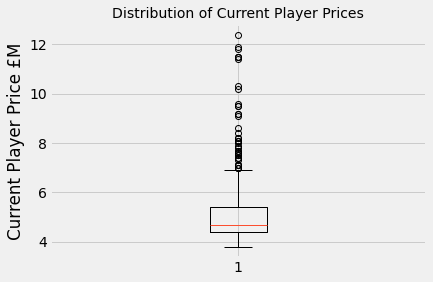

In [1147]:
# We'll first find out how player prices are distributed
plt.boxplot(elements_df.now_cost/10); # divided by 10 as the base values are measured in hundreds of thousands

plt.title("Distribution of Current Player Prices", fontsize=14)
plt.ylabel("Current Player Price £M");


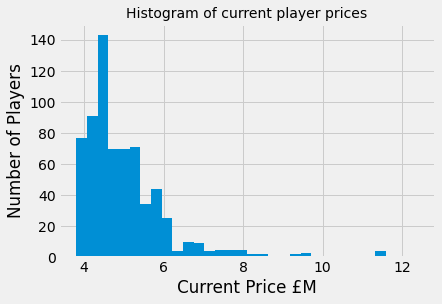

In [1148]:
# Let's look at a price histogram to get the full picture
plt.hist(elements_df.now_cost/10, bins=32, histtype="stepfilled" ); # split into bins of 0.25M
plt.title("Histogram of current player prices", fontsize=14)
plt.ylabel("Number of Players")
plt.xlabel("Current Price £M");


In [1149]:
elements_df.now_cost.describe()

count    686.000000
mean      50.676385
std       11.935481
min       38.000000
25%       44.000000
50%       47.000000
75%       54.000000
max      124.000000
Name: now_cost, dtype: float64

### Narrative on Current Cost
We can see that we have a positively skewed current cost distribution that is loosely normal for the player prices. We have no outliers at the lower end of the distributrion with a hard floor at £4M. However it is interesting to note that that we have a significant number of players who's prices are considered upper outliers. 

* We have an interquartile range of £1M (or 10 on the dataset scale)
* The max is Q3 + IQMx1.5 where Q3 = £5.4M, IQM=£1.5M thus max = 5.4 + 1x1.5 = £7.1M
* So all the prices above £7.1M are considered outliers on this measurement.
* It follows that these outlier players must have some special value that sets them apart. We'll call these players "special" for now as the pricing mechanism has decided that they should be outliers.

Let's see how many players are considered "special":

In [1150]:
# Let's create a suitably ego centric data set of special players. We'll later find out how special they really are!!
special = elements_df[elements_df.now_cost>71]

In [1151]:
print(special.shape) # 36 special players - I wonder how they're split by position. We'll assume attackers mainly!
special.tail() 

(34, 67)


,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
550,100.0,75.0,78830,1,-1,10,-10,7,4,6.7,4.7,2,Harry,6.2,388,True,,2021-03-11T23:30:26.054061Z,115,78830.jpg,7.1,Kane,43.0,False,None,a,17,6,184,6677954,209650,4848139,15007,0.5,16.0,Kane,2273,16,13,9,25,0,0,0,1,0,0,31,664,986.2,510.7,1081.0,257.5,2,1,31,1,8,5,4,1,NaN,,1.0,,1.0,
552,25.0,100.0,85971,-1,1,5,-5,7,3,1.2,4.4,1,Heung-Min,4.4,390,True,Muscle injury - 25% chance of playing,2021-03-14T20:00:21.893998Z,95,85971.jpg,6.4,Son,51.5,False,None,d,17,6,179,7327402,42545,5658858,288815,0.5,18.8,Son,2354,13,9,11,22,0,0,0,0,0,0,22,592,811.8,738.6,771.0,232.5,5,2,10,7,18,10,6,5,1.0,,4.0,,4.0,
556,100.0,100.0,108823,0,0,-6,6,0,3,2.3,1.8,1,Bamidele,1.8,394,False,,2021-01-22T16:30:27.033912Z,74,108823.jpg,1.6,Alli,0.6,False,None,a,17,6,14,36596,2194,257347,940,0.2,1.9,Alli,231,0,1,1,3,0,0,0,0,0,0,0,44,40.0,65.5,43.0,14.7,405,172,278,161,333,160,370,167,NaN,,NaN,,3.0,
573,100.0,100.0,36903,1,-1,1,-1,2,3,8.5,8.0,1,Gareth,8.0,543,False,,2021-02-11T00:00:28.318037Z,96,36903.jpg,4.8,Bale,12.7,False,None,a,17,6,58,1091558,237380,190808,14565,0.8,6.0,Bale,552,5,2,3,8,0,0,0,1,0,0,8,187,274.8,168.2,245.0,68.8,188,73,176,109,120,70,164,87,2.0,,2.0,,2.0,
652,0.0,0.0,102057,0,0,-4,4,0,4,0.0,0.0,0,Raúl,0.0,460,False,Head injury - Unknown return date,2020-11-29T21:30:19.440583Z,81,102057.jpg,4.3,Jiménez,4.5,False,None,i,20,39,43,1159113,77,2214138,823,0.0,5.3,Jiménez,824,4,1,4,10,1,0,0,0,0,0,7,148,177.4,96.2,275.0,55.0,259,28,239,38,99,37,221,34,NaN,,NaN,,1.0,


POINTS

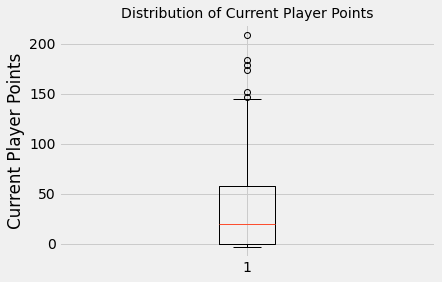

In [1152]:
# Let's look at the points distributions in isolations
plt.boxplot(elements_df.total_points); # divided by 10 as the base values are measured in hundreds of thousands

plt.title("Distribution of Current Player Points", fontsize=14)
plt.ylabel("Current Player Points");

Text(0.5, 0, 'Total points to date')

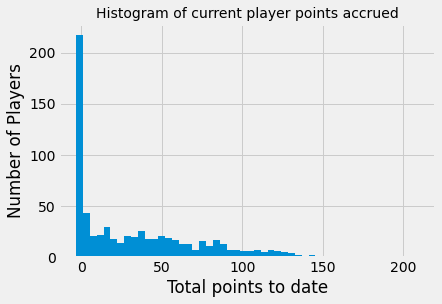

In [1153]:
plt.hist(elements_df.total_points, bins=50, histtype="stepfilled" ); # split into bins of 0.25M
plt.title("Histogram of current player points accrued", fontsize=14)
plt.ylabel("Number of Players")
plt.xlabel("Total points to date")

In [1154]:
# It seems a lot of players have bareley scored! How many?
print(f'{elements_df[elements_df.total_points==0].shape[0]} players have not scored')
print(f'{elements_df[elements_df.total_points<5].shape[0]} players have scored less than five points')

188 players have not scored
250 players have scored less than five points


**Over a quarter of players have not scored and over a third of players have scored under five points!!**

In [1155]:
elements_df.total_points.describe()

count    686.000000
mean      34.667638
std       39.185321
min       -3.000000
25%        0.000000
50%       20.000000
75%       58.000000
max      209.000000
Name: total_points, dtype: float64

### Narrative on Total Points
* We have an interquartile range of 56 points
* The max is Q3 + IQMx1.5 where Q3 = 56, IQM=56 thus max = 56 + 56x1.5 = 140
* So all the points scorers abive 140 are considered outliers
* It follows that these high scoring players have had a special performance regardless of the perception of them. 

It's worth noting that we have yet discriminated based on position. This is for the full player set regardless of position. 

We should make a standalone dataset to contain these over achievers! 

In [1156]:
# Create a df of over achievers
performers = elements_df[elements_df.total_points>140][["web_name", "element_type", "total_points", "now_cost"]]

In [1157]:
performers

,web_name,element_type,total_points,now_cost
33,Martínez,1,152,54
278,Vardy,4,147,102
312,Bamford,4,145,67
350,Salah,3,174,124
376,Gündogan,3,142,62
417,Fernandes,3,209,115
550,Kane,4,184,115
552,Son,3,179,95


#### Points by position
Let's discrimate by position surely we want to be comparing likle for like. After all when playing the game as a manager it's not yet clear how we compare a goalkeeper with an attacker

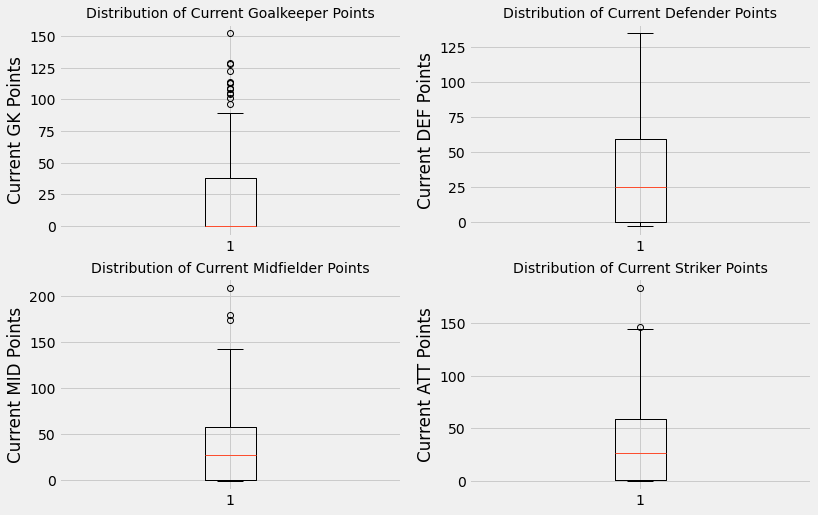

In [1158]:
goalkeeper = elements_df[elements_df.element_type==1]
defender = elements_df[elements_df.element_type==2]
midfielder = elements_df[elements_df.element_type==3]
striker = elements_df[elements_df.element_type==4]


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].boxplot(goalkeeper.total_points); # divided by 10 as the base values are measured in hundreds of thousands
axs[0,0].set_title("Distribution of Current Goalkeeper Points", fontsize=14)
axs[0,0].set_ylabel("Current GK Points");

axs[0,1].boxplot(defender.total_points); # divided by 10 as the base values are measured in hundreds of thousands
axs[0,1].set_title("Distribution of Current Defender Points", fontsize=14)
axs[0,1].set_ylabel("Current DEF Points");

axs[1,0].boxplot(midfielder.total_points); # divided by 10 as the base values are measured in hundreds of thousands
axs[1,0].set_title("Distribution of Current Midfielder Points", fontsize=14)
axs[1,0].set_ylabel("Current MID Points");

axs[1,1].boxplot(striker.total_points); # divided by 10 as the base values are measured in hundreds of thousands
axs[1,1].set_title("Distribution of Current Striker Points", fontsize=14)
axs[1,1].set_ylabel("Current ATT Points");

Let's create a new data set that stores all the performers when we look for outliers  by position. Interesting to see that the Median goalkeeper points tally is zero. This must be where all our low points scorers are stored!

Let's store all the elite players (by position) in a new dataset.

In [1159]:
# Create a data set of player value... i.e. current points and cost
value = elements_df[["id", "web_name", "element_type", "total_points", "now_cost"]]

# Create an empty dataset that will store our elite performers
elite = pd.DataFrame(columns=value.columns)

# Create a list of the separate datasets
positions = [goalkeeper, defender, midfielder, striker]


#for i in list(range(1,5)): # number of element types, gk, def, mid, att

for i, j in enumerate(positions):
    # Store the stats for each position
    stats = j.total_points.describe()
    # Calculate the total score above which our outliers reside
    first_quartile = stats[4]
    third_quartile = stats[6]
    IQR = third_quartile-first_quartile
    maximum = third_quartile + 1.5*IQR
    
    outliers = j[j.total_points>maximum]
    elite = elite.append(outliers[["id", "web_name", "element_type", "total_points", "now_cost"]])
    
    #print(i, maximum)

elite.reset_index(inplace=True)
elite.drop(columns="index", inplace=True)

In [1160]:
# Review the elite dataset
elite

,id,web_name,element_type,total_points,now_cost
0,8,Leno,1,101,50
1,12,Martínez,1,152,54
2,96,Pope,1,128,56
3,548,Mendy,1,113,51
4,128,Guaita,1,105,48
5,516,Areola,1,109,46
6,217,Schmeichel,1,114,55
7,213,Meslier,1,122,46
8,278,Ederson,1,129,61
9,383,Lloris,1,113,56


Our new elite performers set contains all the players in the previous set but now includes 3 more players: 2 goalkeepers and 1 midfielder. It's Interesting that neither of the methods uncovers any elite performance defenders!

Note: This particular set seemed to shift heavily toward goalkeepers after gw 28. This is still likely to be caused by the number of goalkeepers in each squad that simply don't play. However there's a question mark against this now!!??

In [1161]:
random_gk = goalkeeper[goalkeeper.total_points>50].second_name.sample(n=2).values.tolist()
random_def = defender[defender.total_points>50].second_name.sample(n=2).values.tolist()
random_mid = midfielder[midfielder.total_points>50].second_name.sample(n=2).values.tolist()
random_att = striker[striker.total_points>50].second_name.sample(n=2).values.tolist()

In [1162]:
random_def

['Boly', 'Cabral Semedo']

In [1163]:
for i, j in enumerate(random_gk):
    print(j)
#     plt.annotate(j, (defender[defender.second_name==j].total_points.values[0], 
#                      defender[defender.second_name==j].total_points.values[0]))

Johnstone
Meslier


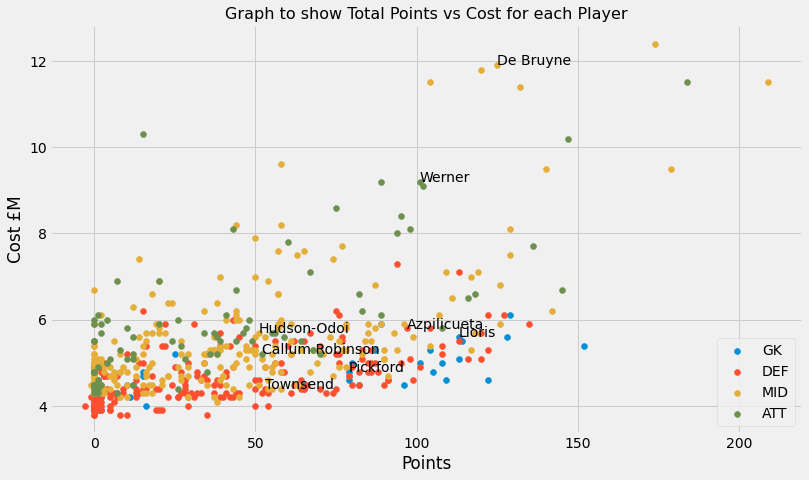

In [1164]:
# Plot out each players points vs cost.
plt.figure(figsize=(12,7))

# Set some samples of each position to annotate the graph with
random_gk = goalkeeper[goalkeeper.total_points>50].web_name.sample(n=2).values.tolist()
random_def = defender[defender.total_points>50].web_name.sample(n=2).values.tolist()
random_mid = midfielder[midfielder.total_points>50].web_name.sample(n=2).values.tolist()
random_att = striker[striker.total_points>50].web_name.sample(n=2).values.tolist()

# Plot goalkeeper values
plt.scatter(goalkeeper.total_points, goalkeeper.now_cost/10,  label="GK") # divide by 10 to get £M

# Random annotation
for i, j in enumerate(random_gk):
    plt.annotate(j, (goalkeeper[goalkeeper.web_name==j].total_points.values[0], 
                     goalkeeper[goalkeeper.web_name==j].now_cost.values[0]/10))

# Plot defender values
plt.scatter(defender.total_points, defender.now_cost/10, label = "DEF")

# Random annotation
for i, j in enumerate(random_def):
    plt.annotate(j, (defender[defender.web_name==j].total_points.values[0], 
                     defender[defender.web_name==j].now_cost.values[0]/10))

# Plot Midfielder values
plt.scatter(midfielder.total_points, midfielder.now_cost/10, label = "MID")

# Random annotation
for i, j in enumerate(random_mid):
    plt.annotate(j, (midfielder[midfielder.web_name==j].total_points.values[0], 
                     midfielder[midfielder.web_name==j].now_cost.values[0]/10))

# Plot Attacker values
plt.scatter(striker.total_points, striker.now_cost/10, label = "ATT")

# Random annotation
for i, j in enumerate(random_att):
    plt.annotate(j, (striker[striker.web_name==j].total_points.values[0], 
                     striker[striker.web_name==j].now_cost.values[0]/10))

plt.title("Graph to show Total Points vs Cost for each Player", fontsize=16)
plt.xlabel("Points")
plt.ylabel("Cost £M")



plt.legend(loc="lower right");

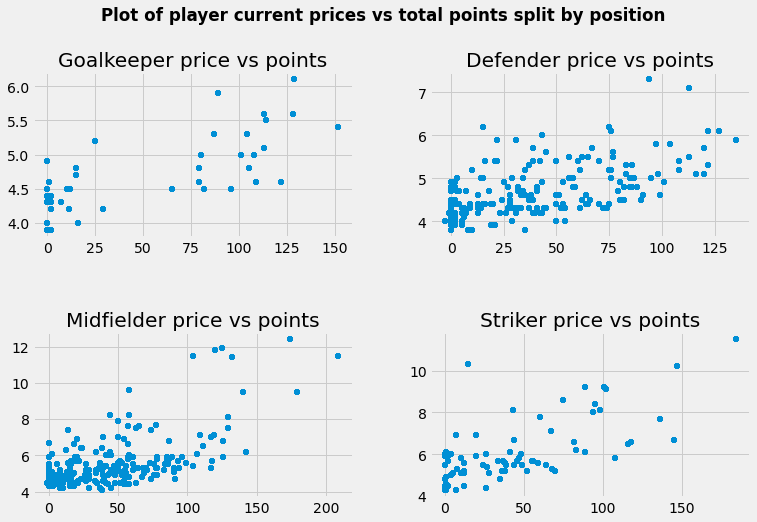

In [1165]:
# Let's look at the same scatter but split by position, 
# Dataset codes as follows. 1-GK, 2-DEF, 3-MID, 4-ATT
fig, axs = plt.subplots(2, 2, figsize = (12, 8))
plt.suptitle("Plot of player current prices vs total points split by position", fontweight='bold')


#Plot goalkeeper cost vs points
axs[0,0].scatter(goalkeeper.total_points, goalkeeper.now_cost/10, marker="+")
axs[0,0].set_title("Goalkeeper price vs points")

#Plot goalkeeper cost vs points
axs[0,1].scatter(defender.total_points, defender.now_cost/10, marker="+")
axs[0,1].set_title("Defender price vs points")

#Plot goalkeeper cost vs points
axs[1,0].scatter(midfielder.total_points, midfielder.now_cost/10, marker="+")
axs[1,0].set_title("Midfielder price vs points")

#Plot goalkeeper cost vs points
axs[1,1].scatter(striker.total_points, striker.now_cost/10, marker="+")
axs[1,1].set_title("Striker price vs points");

plt.tight_layout(pad=4)

**Note:** If the plot count looks small for some of the positions it's because multiple players have the exact same plot point. For example, 20 defenders have a cost of 40 (£4M) and 0 points. We can only see a single plot point in this case but it is not that the data is missing, just exactly overlayed so as to be invisible. Goalkeepers are worst hit by this.

### Value
My hunch is that winning managers get a good proportion of the elite players into their teams while avoiding overvalued players and employing undervalued players. Now this is hardly cutting edge statements but it is worth stating as a sort of null hypothesis, in fact why not state it:

**"Winnning managers employ some mix of elite players and under-valued players while largely avoiding over-valued players."**

We have previously isolated our elite performers. Now how should we measure value? Let's start with the following:
+ Overvalued players cost more than £8M while scoring less than 150 points 
+ Undervalued players cost less than £8M while scoring more than 100 points

Note that these boundaries are arbitrary and may not ultimately be suitable. It is my current belief that the game is weighted slightly in favour of points totals rather than value. However this is a good place to start. 

**VALUE IS NOT EVERYTHING**




In [1166]:
good_value = value[(value.now_cost<80) & (value.total_points>100)]
poor_value = value[(value.now_cost>80) & (value.total_points<150)]

In [1167]:
# Now let's add a value feature that provides a measure of points per unit cost
good_value["value"] = good_value.total_points / good_value.now_cost
poor_value["value"] = poor_value.total_points / poor_value.now_cost

In [1168]:
good_val_sorted = good_value.sort_values(by=['value'], ascending=False)

In [1169]:
print(good_val_sorted.shape)
good_val_sorted

(42, 6)


,id,web_name,element_type,total_points,now_cost,value
33,12,Martínez,1,152,54,2.814815
323,213,Meslier,1,122,46,2.652174
261,516,Areola,1,109,46,2.369565
310,200,Dallas,2,120,51,2.352941
378,273,Stones,2,122,53,2.301887
376,271,Gündogan,3,142,62,2.290323
621,435,Cresswell,2,135,59,2.288136
124,96,Pope,1,128,56,2.285714
48,42,Targett,2,116,51,2.274510
164,548,Mendy,1,113,51,2.215686


In [1170]:
poor_val_sorted = poor_value.sort_values(by=["value"])

In [1171]:
print(poor_val_sorted.shape)
poor_val_sorted

(18, 6)


,id,web_name,element_type,total_points,now_cost,value
373,268,Agüero,4,15,103,0.145631
652,460,Jiménez,4,43,81,0.530864
155,119,Pulisic,3,44,82,0.536585
573,543,Bale,3,58,96,0.604167
163,500,Havertz,3,58,82,0.707317
418,303,Martial,4,75,86,0.872093
3,4,Aubameyang,3,104,115,0.904348
387,282,Jesus,4,89,92,0.967391
347,251,Mané,3,120,118,1.016949
377,272,De Bruyne,3,125,119,1.050420


#### We chose sensible boundary values
We can see when comparing the two value tables that we chose "sensible" boundary values as only one player from the poor value table actually has a better value score than any of the goo value players. This Mahrez who would rank third bottom of the good value table if the cost boundary had been raised by £0.2M or the total points been lowered to 125points. 

## Predicting Value

It's all very well knowing where the value is today (or more precisely: yesterday), but we want to predict value, right?!. We want to know where the value is going to be tomorrow and preferably for the next few weeks or even longer!! How can we do this?

#### Plan
1. We can check the value of all players after gameweek one and store the good and bad value players in a variable - dataframe. 
2. We can measure the value again after gameweek two, but this will be a rolling measure of both GW1 and GW2. Again we'll append the good and bad value players to their respective data sets....
3. ... And so on through GW3 up until the current date.
4. Then we can query the data sets and find out what proportion of value, good or bad, was set at various points. The detail of how we'll achieve this isn't know yet!!
5. The hope is that a decent proportion of the value, good and bad, is set by an early stage of the season. At that point a manager can select wisely from a smaller subset of the players.
6. Another hope is that where value is not set at an early stage, we may be able to understand how a player moves through the value brackets. For example, if a player moved from a lower value to upper value bracket what predictors indicated that this was possible, if any. 
7. Do players improve, fall off with no indication that this is about to happen? If so then accurate prediction may be hard. However we must always believe that an edge can be found!

**PT1** To achieve the first part of this task we can't just set arbitrary value boundaries like we did with the current data. As we move through the gameweeks these values will change. To start with we'll just producing a dataset that gets the rolling points values and also stores the updated costs and assigns a value metric. 

In [1172]:
# Let's review our master data set
data.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840


In [1173]:
# Ok we're only going to need a fraction of these features for our current narrow requirements
value_set = data[["element", "fixture", "round", "value", "total_points"]]

In [1174]:
value_set.head(2)

,element,fixture,round,value,total_points
0,1,2,1,70,0
1,1,9,2,69,0


In [1175]:
# I think it would be advantageous to join the player names so we can apply our domain knowledge when the time comes
# We can get these from the elements dataset, we'll need the id as well for the join
names = elements_df[["id", "first_name", "web_name"]]

In [1176]:
names.head(2)

,id,first_name,web_name
0,1,Mesut,Özil
1,2,Sokratis,Sokratis


In [1177]:
# Ok let's join the two data sets into one
info = value_set.merge(names, how="left", left_on="element", right_on="id").drop("id", axis=1)

In [1178]:
info
# ok good this is our base dataset for this task

,element,fixture,round,value,total_points,first_name,web_name
0,1,2,1,70,0,Mesut,Özil
1,1,9,2,69,0,Mesut,Özil
2,1,23,3,69,0,Mesut,Özil
3,1,29,4,68,0,Mesut,Özil
4,1,44,5,68,0,Mesut,Özil
...,...,...,...,...,...,...,...
17794,683,276,28,45,0,Jaden,Philogene-Bidace
17795,684,260,27,45,0,Shane,Flynn
17796,684,274,28,45,0,Shane,Flynn
17797,685,268,27,40,0,Gaetano,Berardi


In [1179]:
# Let's change the value feature to be called cost to avoid confusion with our value features
info.rename(columns={"value": "cost"}, inplace=True)

In [1180]:
# Create our value features
info["cum_points"] = 0
info["local_val"] = 0
info["cum_val"] = 0

In [1181]:
# Let's check we've no missing data
info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17799 entries, 0 to 17798
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   element       17799 non-null  int64 
 1   fixture       17799 non-null  int64 
 2   round         17799 non-null  int64 
 3   cost          17799 non-null  int64 
 4   total_points  17799 non-null  int64 
 5   first_name    17799 non-null  object
 6   web_name      17799 non-null  object
 7   cum_points    17799 non-null  int64 
 8   local_val     17799 non-null  int64 
 9   cum_val       17799 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 1.5+ MB


In [1182]:
info.head(4)

,element,fixture,round,cost,total_points,first_name,web_name,cum_points,local_val,cum_val
0,1,2,1,70,0,Mesut,Özil,0,0,0
1,1,9,2,69,0,Mesut,Özil,0,0,0
2,1,23,3,69,0,Mesut,Özil,0,0,0
3,1,29,4,68,0,Mesut,Özil,0,0,0


In [1183]:
# We can group the data set by round so that we have all the player data for each round
rounded = info.groupby("round")

In [1184]:
# We can investigate this grouping by checking the number of data points in each round
rounded.size()

round
1      424
2      539
3      554
4      563
5      583
6      590
7      597
8      600
9      601
10     603
11     541
12     607
13     607
14     611
15     614
16     491
17     560
18     395
19     956
20     644
21     650
22     663
23     667
24     802
25     742
26    1155
27     755
28     685
dtype: int64

#### Observations
Interesting that some of the rounds seem to have low, or high, counts. We can assume that this is due to double 
game weeks or short game weeks. We can check easily on the FPL website.. spot check gw 26 and gw 18!\

We can see from the website that these anomolous gameweeks were indeed extended or shortened.


#### Moving on!
So, moving on with part 1 we can isolate each gameweek from our rounded dataframe by using the get_group tool. 

In [1185]:
# Get group 20
gw_20 = rounded.get_group(20)
gw_20

,element,fixture,round,cost,total_points,first_name,web_name,cum_points,local_val,cum_val
19,1,197,20,67,0,Mesut,Özil,0,0,0
47,2,197,20,48,0,Sokratis,Sokratis,0,0,0
75,3,197,20,54,2,David,David Luiz,0,0,0
103,4,197,20,113,0,Pierre-Emerick,Aubameyang,0,0,0
131,5,197,20,46,2,Cédric,Cédric,0,0,0
...,...,...,...,...,...,...,...,...,...,...
17487,640,192,20,55,0,Amad,Diallo,0,0,0
17497,641,195,20,60,0,Jean-Philippe,Mateta,0,0,0
17507,642,194,20,70,1,Willian José,Willian José,0,0,0
17517,643,197,20,45,0,Alexandre,Jankewitz,0,0,0


In [1186]:
# From there we can extract information about only that group, e.g the maximum points scored
gw_20.total_points.max()

17

In [1187]:
# Indeed we can extract the means of all rounds by simply calling the mean. Not that it makes sense to do so.
rounded.mean().head(4)

,element,fixture,cost,total_points,cum_points,local_val,cum_val
round,,,,,,,
1,280.716981,4.485849,53.042453,1.665094,0.0,0.0,0.0
2,270.000000,13.500928,53.428571,1.493506,0.0,0.0,0.0
3,277.500000,23.454874,53.185921,1.456679,0.0,0.0,0.0
4,281.262877,33.507993,52.950266,1.506217,0.0,0.0,0.0


In [1188]:
# So we need to iterate through each of the rounds, create a value for each player in that round.

# The best way to do this is probably to go player by player without grouping by rounds. 
# Grouping after we've created the new value features

In [1189]:
current_player = info[info.element==683]
current_player

,element,fixture,round,cost,total_points,first_name,web_name,cum_points,local_val,cum_val
17793,683,259,27,45,0,Jaden,Philogene-Bidace,0,0,0
17794,683,276,28,45,0,Jaden,Philogene-Bidace,0,0,0


In [1190]:
info.element.nunique()

685

In [1191]:
range(1, info.element.nunique())

range(1, 685)

In [1192]:
# Set an empty dataset to store the cumulative player value
cumulative = pd.DataFrame(columns=info.columns)

for j in range(1, info.element.nunique()):
    # Create a df with only the current player's history 
    current_player = info[info.element==j]
    
    # Loop through this history and populate the value features based on the rules we created
    for i in range(current_player.shape[0]):
        if i == 0:
            current_player["cum_points"].iloc[i] = current_player["total_points"].iloc[i]
            current_player["local_val"].iloc[i] = current_player["total_points"].iloc[i] / current_player["cost"].iloc[i]
            current_player["cum_val"].iloc[i] = current_player["cum_points"].iloc[i] / current_player["cost"].iloc[i]
        else:
            current_player["cum_points"].iloc[i] = current_player["total_points"].iloc[i] + current_player["cum_points"].iloc[i-1]
            current_player["local_val"].iloc[i] = current_player["total_points"].iloc[i] / current_player["cost"].iloc[i]
            current_player["cum_val"].iloc[i] = current_player["cum_points"].iloc[i] / current_player["cost"].iloc[i]

    # Add the player frame with populated new feature values to our cumulative dataframe
    cumulative = cumulative.append(current_player)
        

In [1193]:
cumulative.head(3)

,element,fixture,round,cost,total_points,first_name,web_name,cum_points,local_val,cum_val
0,1,2,1,70,0,Mesut,Özil,0,0.0,0.0
1,1,9,2,69,0,Mesut,Özil,0,0.0,0.0
2,1,23,3,69,0,Mesut,Özil,0,0.0,0.0


In [1194]:
# Let's save this cumulative dataset to file
cumulative.to_csv("cumulative_points.csv", index=False)

In [1195]:
Firmino = cumulative[cumulative.web_name=='Martínez']
Firmino

,element,fixture,round,cost,total_points,first_name,web_name,cum_points,local_val,cum_val
308,12,10,2,45,13,Emiliano,Martínez,13,0.288889,0.288889
309,12,22,3,45,6,Emiliano,Martínez,19,0.133333,0.422222
310,12,30,4,46,3,Emiliano,Martínez,22,0.065217,0.478261
311,12,43,5,47,9,Emiliano,Martínez,31,0.191489,0.659574
312,12,50,6,48,3,Emiliano,Martínez,34,0.062500,0.708333
313,12,59,7,48,0,Emiliano,Martínez,34,0.000000,0.708333
314,12,69,8,48,6,Emiliano,Martínez,40,0.125000,0.833333
315,12,79,9,48,1,Emiliano,Martínez,41,0.020833,0.854167
316,12,98,10,48,1,Emiliano,Martínez,42,0.020833,0.875000
317,12,118,12,48,11,Emiliano,Martínez,53,0.229167,1.104167


In [1196]:
Firmino.total_points.sum()

152

**Pt1 Summary**
Ok so we've succesfully collected all the player value stats, both cumulative and local, and stored them in a single dataframe. This completes points 1- 3 of our original plan at the top of the section. Now we need to figure out a way to evaluate and display this new data so that we may gain insight. 

**PT2** 
Evaluate the value data\
Let's start with some visualisations

We know which are the best and worst value players from our original investigation. Let's plot these players cumulative values on a chart to see how they moved through the gameweeks. We'll need to take into account that some of the worst value players have maybe not played due to injury so we'll set a minimum minutes played to ensure it's a fair comparison.

In [1197]:
# Let's quickly refer to our good and bad value datasets.
good_val_sorted

,id,web_name,element_type,total_points,now_cost,value
33,12,Martínez,1,152,54,2.814815
323,213,Meslier,1,122,46,2.652174
261,516,Areola,1,109,46,2.369565
310,200,Dallas,2,120,51,2.352941
378,273,Stones,2,122,53,2.301887
376,271,Gündogan,3,142,62,2.290323
621,435,Cresswell,2,135,59,2.288136
124,96,Pope,1,128,56,2.285714
48,42,Targett,2,116,51,2.274510
164,548,Mendy,1,113,51,2.215686


In [1198]:
poor_val_sorted

,id,web_name,element_type,total_points,now_cost,value
373,268,Agüero,4,15,103,0.145631
652,460,Jiménez,4,43,81,0.530864
155,119,Pulisic,3,44,82,0.536585
573,543,Bale,3,58,96,0.604167
163,500,Havertz,3,58,82,0.707317
418,303,Martial,4,75,86,0.872093
3,4,Aubameyang,3,104,115,0.904348
387,282,Jesus,4,89,92,0.967391
347,251,Mané,3,120,118,1.016949
377,272,De Bruyne,3,125,119,1.050420


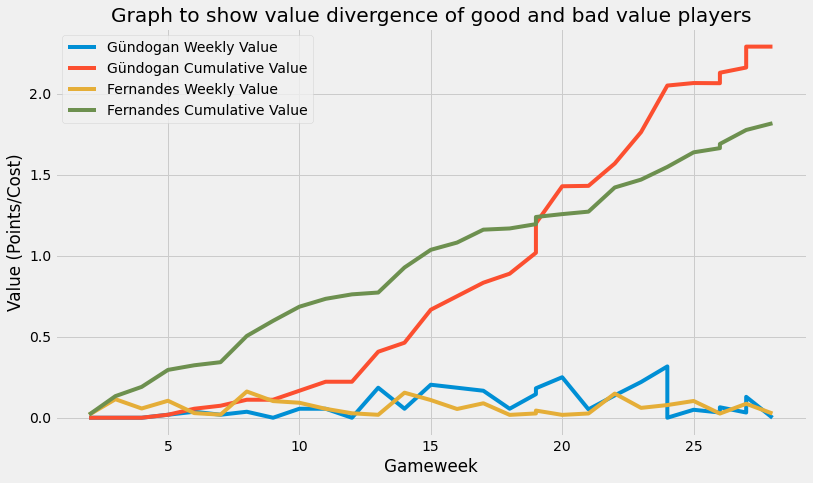

In [1199]:
# Let's plot Martinez (good) against Mané (bad)

# Save the players to variables
good, bad = "Gündogan", "Fernandes"

# Save the values to variables
good_local = cumulative[cumulative.web_name==good]
bad_local = cumulative[cumulative.element==302] # Put Bruno Fernandes element number in as there are 2 Fernandes
good_cum = cumulative[cumulative.web_name==good]
bad_cum = cumulative[cumulative.element==302]

plt.figure(figsize=(12,7))
plt.plot(good_local["round"], good_local.local_val.values, label=f"{good} Weekly Value")
plt.plot(good_cum["round"], good_cum.cum_val.values, label=f"{good} Cumulative Value")
plt.plot(bad_local["round"], bad_local.local_val.values, label=f"{bad} Weekly Value")
plt.plot(bad_cum["round"], bad_cum.cum_val.values, label=f"{bad} Cumulative Value")

plt.title("Graph to show value divergence of good and bad value players")
plt.xlabel("Gameweek")
plt.ylabel("Value (Points/Cost)")

plt.legend()
plt.show();

Ok that plot is good, it shows that Dallas' value permanently exceeded that of Vardy around GW 8 and the gap widened from that point onwards. What about if we can create a suite of these plots, let's say 8 to see if gw 8 is a good estimator for when good value becomes permanently good value?!

In [1200]:
import random

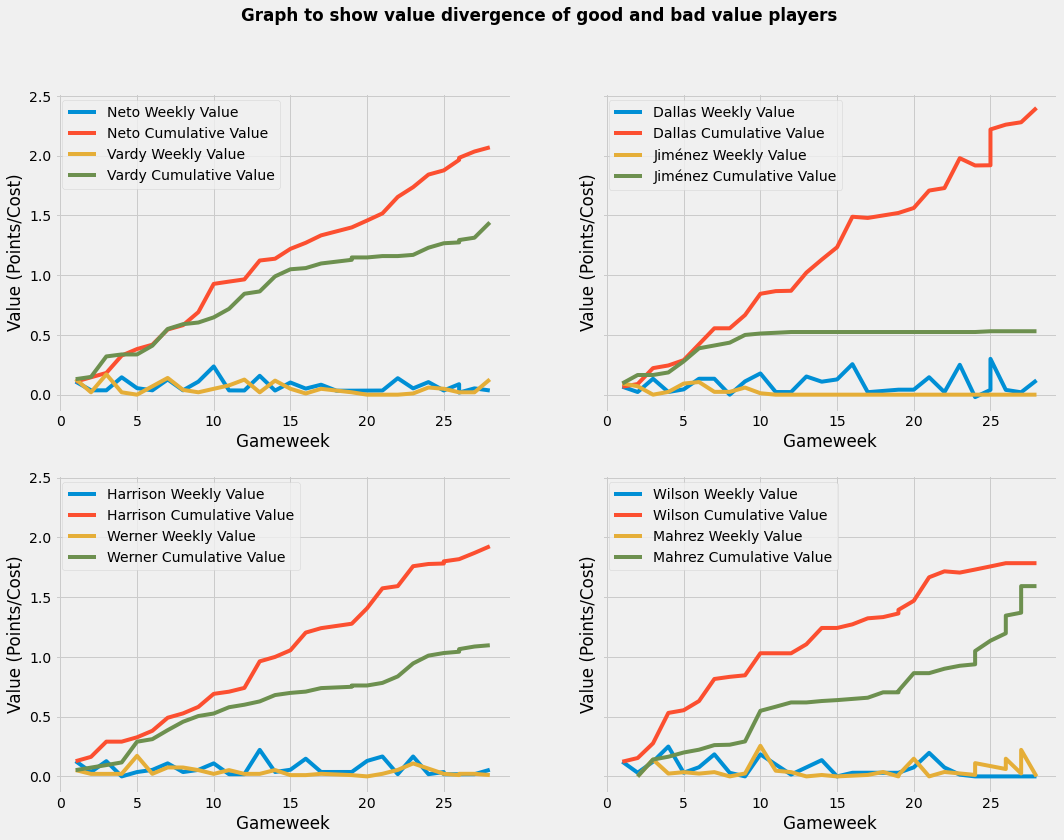

In [1203]:
# Create a random choice from each of the good/bad dataframes to compare with each other
good_list = random.sample(good_val_sorted.id.values.tolist(), k=4)
bad_list = random.sample(poor_val_sorted.id.values.tolist(), k=4)



fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
plt.suptitle("Graph to show value divergence of good and bad value players", fontweight="bold")

for i, (j, k) in enumerate(zip(good_list, bad_list)):
    
    good_local = cumulative[cumulative.element==good_list[i]] # Note that element is the id feature in cumulative df
    bad_local = cumulative[cumulative.element==bad_list[i]]
    good_cum = cumulative[cumulative.element==good_list[i]]
    bad_cum = cumulative[cumulative.element==bad_list[i]]
    
    good_name = good_val_sorted[good_val_sorted.id==good_list[i]].web_name.values[0]
    bad_name = poor_val_sorted[poor_val_sorted.id==bad_list[i]].web_name.values[0]
    
    if i < 2:
        axs[i-i, i].plot(good_local["round"], good_local.local_val.values, label=f"{good_name} Weekly Value")
        axs[i-i, i].plot(good_cum["round"], good_cum.cum_val.values, label=f"{good_name} Cumulative Value")
        axs[i-i, i].plot(bad_local["round"], bad_local.local_val.values, label=f"{bad_name} Weekly Value")
        axs[i-i, i].plot(bad_cum["round"], bad_cum.cum_val.values, label=f"{bad_name} Cumulative Value")
        axs[i-i, i].set_xlabel("Gameweek")
        axs[i-i, i].set_ylabel("Value (Points/Cost)")
        axs[i-i, i].legend()
        
    else:
        
        axs[int(i/i), i%2].plot(good_local["round"], good_local.local_val.values, label=f"{good_name} Weekly Value")
        axs[int(i/i), i%2].plot(good_cum["round"], good_cum.cum_val.values, label=f"{good_name} Cumulative Value")
        axs[int(i/i), i%2].plot(bad_local["round"], bad_local.local_val.values, label=f"{bad_name} Weekly Value")
        axs[int(i/i), i%2].plot(bad_cum["round"], bad_cum.cum_val.values, label=f"{bad_name} Cumulative Value")
        axs[int(i/i), i%2].set_xlabel("Gameweek")
        axs[int(i/i), i%2].set_ylabel("Value (Points/Cost)")
        axs[int(i/i), i%2].legend()





plt.show();
        
        
   
                      




We can repeat the above process but for all players in the data. However, to avoid nonsense plots lets limit the search to players who have scored more than the mean total score which is 33. 

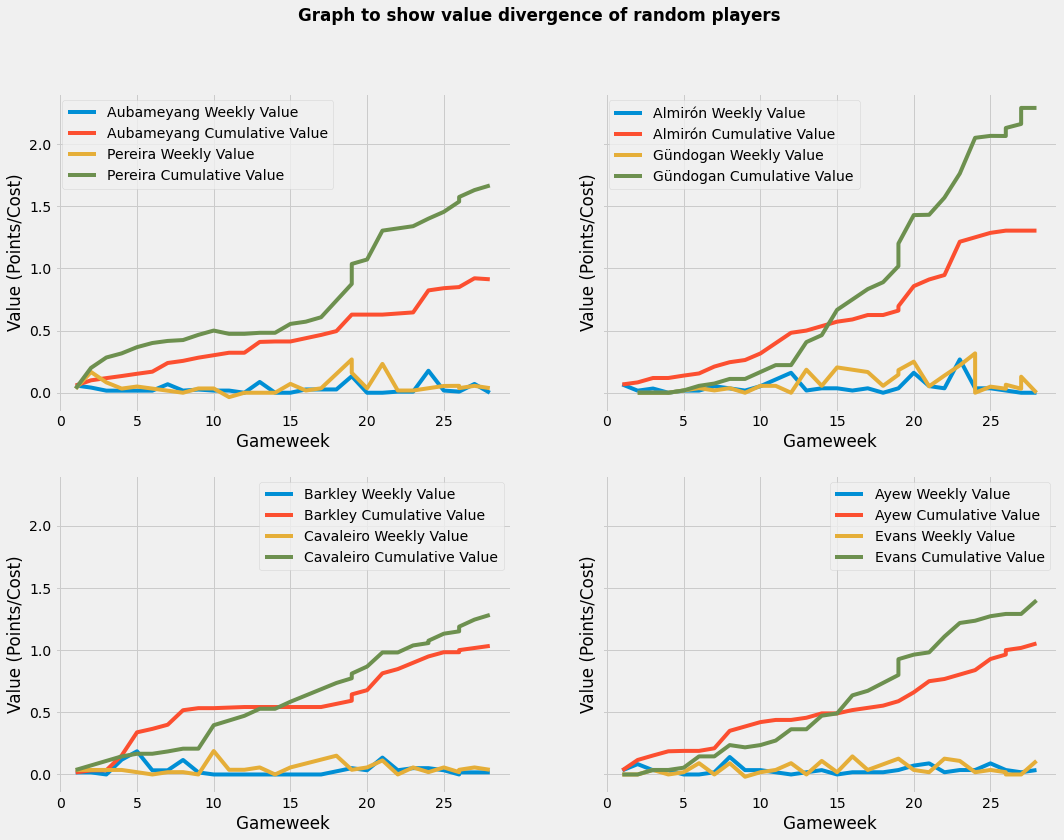

number of players with more than 55 points: 183
players compared: ['Aubameyang', 'Pereira', 'Almirón', 'Gündogan', 'Barkley', 'Cavaleiro', 'Ayew', 'Evans']


In [1204]:
points = elements_df[["first_name", "web_name", "total_points", "id"]]
x = 55
greater_than_mean_points = points[points.total_points>x] # We have chosen the 75percentile which is 55points!
greater_than_mean_list = greater_than_mean_points.id.tolist()


# Alternatively choose random players from the main list for ease we'll call it good list bad list
a_list = random.sample(greater_than_mean_list, k=4)
b_list = random.sample(greater_than_mean_list, k=4)

names = []

fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
plt.suptitle("Graph to show value divergence of random players", fontweight="bold")

for i, (j, k) in enumerate(zip(a_list, b_list)):
    
    good_local = cumulative[cumulative.element==a_list[i]] # Note that element is the id feature in cumulative df
    bad_local = cumulative[cumulative.element==b_list[i]]
    good_cum = cumulative[cumulative.element==a_list[i]]
    bad_cum = cumulative[cumulative.element==b_list[i]]
    
    good_name = elements_df[elements_df.id==a_list[i]].web_name.values[0]
    bad_name = elements_df[elements_df.id==b_list[i]].web_name.values[0]
    names.append(good_name)
    names.append(bad_name)
    
    

    if i < 2:
        axs[i-i, i].plot(good_local["round"], good_local.local_val.values, label=f"{good_name} Weekly Value")
        axs[i-i, i].plot(good_cum["round"], good_cum.cum_val.values, label=f"{good_name} Cumulative Value")
        axs[i-i, i].plot(bad_local["round"], bad_local.local_val.values, label=f"{bad_name} Weekly Value")
        axs[i-i, i].plot(bad_cum["round"], bad_cum.cum_val.values, label=f"{bad_name} Cumulative Value")
        axs[i-i, i].set_xlabel("Gameweek")
        axs[i-i, i].set_ylabel("Value (Points/Cost)")
        axs[i-i, i].legend()

    else:

        axs[int(i/i), i%2].plot(good_local["round"], good_local.local_val.values, label=f"{good_name} Weekly Value")
        axs[int(i/i), i%2].plot(good_cum["round"], good_cum.cum_val.values, label=f"{good_name} Cumulative Value")
        axs[int(i/i), i%2].plot(bad_local["round"], bad_local.local_val.values, label=f"{bad_name} Weekly Value")
        axs[int(i/i), i%2].plot(bad_cum["round"], bad_cum.cum_val.values, label=f"{bad_name} Cumulative Value")
        axs[int(i/i), i%2].set_xlabel("Gameweek")
        axs[int(i/i), i%2].set_ylabel("Value (Points/Cost)")
        axs[int(i/i), i%2].legend()





plt.show();
print(f'number of players with more than {x} points: {len(greater_than_mean_list)}')
print(f'players compared: {names}')       

### Narrative
1. 
2. 
3. 
4. 
5. See andvanced features for value metrics we're currently considering
6. The cumulutive value is a lagging indicator - it is historic. It is not clear how it can be used mid game to indicate whether a player should be considered.
7. We should be looking at how a player's value is trending against a comparison player.
8. We have yet to understand at what point total points overrules value. 


## Sandpit

#### Limiting players to compare to those scoring more than 33

In [1059]:
points = elements_df[["first_name", "web_name", "total_points", "id"]]
greater_than_mean_points = points[points.total_points>55]
greater_than_mean_list = greater_than_mean_points.id.tolist()

In [1060]:
greater_than_mean_list

[4,
 6,
 8,
 11,
 16,
 17,
 18,
 24,
 478,
 12,
 37,
 38,
 41,
 42,
 45,
 46,
 106,
 496,
 514,
 540,
 57,
 62,
 65,
 66,
 67,
 68,
 69,
 74,
 597,
 81,
 88,
 89,
 91,
 92,
 96,
 97,
 100,
 102,
 105,
 109,
 110,
 117,
 118,
 120,
 123,
 232,
 490,
 548,
 128,
 132,
 133,
 137,
 140,
 141,
 489,
 150,
 155,
 156,
 157,
 159,
 162,
 164,
 165,
 166,
 508,
 512,
 181,
 187,
 191,
 373,
 516,
 557,
 562,
 571,
 572,
 217,
 219,
 224,
 228,
 231,
 235,
 239,
 498,
 197,
 198,
 200,
 201,
 202,
 203,
 213,
 492,
 570,
 243,
 244,
 249,
 251,
 252,
 254,
 255,
 259,
 270,
 271,
 272,
 273,
 275,
 276,
 277,
 278,
 281,
 282,
 283,
 284,
 286,
 556,
 291,
 296,
 298,
 300,
 302,
 303,
 306,
 308,
 309,
 313,
 569,
 325,
 339,
 506,
 344,
 483,
 148,
 362,
 363,
 366,
 368,
 369,
 370,
 375,
 376,
 377,
 383,
 386,
 388,
 389,
 390,
 391,
 396,
 405,
 542,
 543,
 412,
 417,
 422,
 481,
 544,
 431,
 432,
 435,
 437,
 445,
 448,
 449,
 450,
 558,
 576,
 454,
 455,
 458,
 459,
 461,
 465,
 466,
 

In [1061]:
a_list = random.sample(greater_than_mean_list, k=4)
b_list = random.sample(greater_than_mean_list, k=4)

In [1062]:
a_list

[291, 449, 363, 272]

In [1063]:
b_list

[162, 12, 67, 362]

In [1064]:
good_local = cumulative[cumulative.element==a_list[i]] # Note that element is the id feature in cumulative df
bad_local = cumulative[cumulative.element==b_list[i]]
good_cum = cumulative[cumulative.element==a_list[i]]
bad_cum = cumulative[cumulative.element==b_list[i]]

In [1070]:
bad_cum.head()

,element,fixture,round,cost,total_points,first_name,web_name,cum_points,local_val,cum_val
9961,362,1,1,50,2,Ryan,Bertrand,2,0.04,0.04
9962,362,17,2,50,-1,Ryan,Bertrand,1,-0.02,0.02
9963,362,20,3,50,8,Ryan,Bertrand,9,0.16,0.18
9964,362,37,4,50,6,Ryan,Bertrand,15,0.12,0.30
9965,362,39,5,50,1,Ryan,Bertrand,16,0.02,0.32


In [1071]:
names = []

In [1072]:
good_name = elements_df[elements_df.id==good_list[i]].web_name.values[0]
bad_name = elements_df[elements_df.id==bad_list[i]].web_name.values[0]
names.append(good_name)
names.append(bad_name)

In [1073]:
names

['Soucek', 'Werner']

In [174]:
elements_df.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam',
       'news', 'news_added', 'now_cost', 'photo', 'points_per_game',
       'second_name', 'selected_by_percent', 'special', 'squad_number',
       'status', 'team', 'team_code', 'total_points', 'transfers_in',
       'transfers_in_event', 'transfers_out', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank',
       'creativity_rank_type', 'threat_rank'

In [1090]:
cumulative[cumulative.web_name=="Fernandes"]

,element,fixture,round,cost,total_points,first_name,web_name,cum_points,local_val,cum_val
8304,302,15,2,105,2,Bruno Miguel,Fernandes,2,0.019048,0.019048
8305,302,19,3,105,12,Bruno Miguel,Fernandes,14,0.114286,0.133333
8306,302,35,4,105,6,Bruno Miguel,Fernandes,20,0.057143,0.190476
8307,302,45,5,105,11,Bruno Miguel,Fernandes,31,0.104762,0.295238
8308,302,55,6,105,3,Bruno Miguel,Fernandes,34,0.028571,0.323810
8309,302,64,7,105,2,Bruno Miguel,Fernandes,36,0.019048,0.342857
8310,302,73,8,105,17,Bruno Miguel,Fernandes,53,0.161905,0.504762
8311,302,84,9,107,11,Bruno Miguel,Fernandes,64,0.102804,0.598131
8312,302,96,10,108,10,Bruno Miguel,Fernandes,74,0.092593,0.685185
8313,302,108,11,109,6,Bruno Miguel,Fernandes,80,0.055046,0.733945


In [252]:
# Strikers
elements_df[elements_df.element_type==4].head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
5,100.0,100.0,59966,0,0,-4,4,2,4,2.5,3.0,1,Alexandre,2.5,6,False,,2021-01-30T23:00:18.185183Z,81,59966.jpg,3.9,Lacazette,4.0,False,None,a,1,3,90,1233450,6747,1280568,21513,0.3,11.1,Lacazette,1440,9,2,6,12,0,0,0,2,0,0,13,314,439.4,237.3,589.0,126.3,75,9,112,12,38,18,47,15,NaN,,3.0,,2.0,
18,NaN,NaN,205533,0,0,-6,6,0,4,0.0,0.5,0,Edward,0.0,22,False,,None,54,205533.jpg,1.9,Nketiah,0.5,False,None,a,1,3,27,54078,227,154827,490,0.0,5.0,Nketiah,317,1,1,0,6,0,0,0,0,0,0,4,84,74.4,58.8,120.0,24.9,358,42,287,44,211,47,334,47,NaN,,NaN,,NaN,
54,25.0,25.0,213345,0,0,0,0,0,4,0.0,0.0,0,Wesley,0.0,48,False,Lack of match fitness - 25% chance of playing,2020-08-15T10:00:11.458856Z,60,213345.jpg,0.0,Moraes,0.0,False,None,d,2,7,0,1488,36,1815,37,0.0,0.0,Wesley,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,683,88,684,89,683,89,684,89,NaN,,NaN,,NaN,
55,0.0,0.0,217487,0,0,-1,1,0,4,0.0,0.0,0,Mbwana,0.0,49,False,Joined Fenerbahce on a permanent deal on 25/9,2020-09-25T09:00:10.072147Z,59,217487.jpg,0.0,Samatta,0.0,False,None,u,2,7,0,1633,0,8447,4,0.0,0.0,Samatta,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,682,87,683,88,682,88,683,88,NaN,,NaN,,NaN,
56,100.0,100.0,221239,0,0,-2,2,0,4,0.4,0.4,1,Keinan,0.4,50,False,,2020-11-24T23:00:18.514322Z,43,221239.jpg,1.0,Davis,8.1,False,None,a,2,7,7,1186159,15768,1651550,15810,0.1,1.6,Davis,69,0,0,0,0,0,0,0,0,0,0,0,20,8.0,17.8,60.0,8.4,461,58,374,54,304,53,400,54,NaN,,NaN,,NaN,


In [128]:
elements_nan = elements_df[elements_df.chance_of_playing_next_round.isna()]

In [129]:
#elements_df.chance_of_playing_next_round.unique()
elements_nan.tail(20) # Wait until end of gameweek

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
642,NaN,NaN,222017,0,0,0,0,0,3,0.0,0.5,0,Conor,0.0,668,False,,None,45,222017.jpg,0.0,Coventry,0.0,False,None,a,19,21,0,216,25,116,15,0.0,0.0,Coventry,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,607,232,598,232,583,229,612,233,NaN,,NaN,,NaN,
643,NaN,NaN,462384,0,0,0,0,0,2,0.0,0.5,0,Jamal,0.0,669,False,,None,40,462384.jpg,0.0,Baptiste,0.0,False,None,a,19,21,0,384,44,214,21,0.0,0.0,Baptiste,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,533,206,515,207,490,194,541,206,NaN,,NaN,,NaN,
644,NaN,NaN,232398,0,0,0,0,0,1,0.0,0.5,0,Nathan,0.0,674,False,,None,40,232398.jpg,0.0,Trott,0.0,False,None,a,19,21,0,192,62,32,11,0.0,0.0,Trott,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,520,53,501,28,476,21,528,53,NaN,,NaN,,NaN,
645,NaN,NaN,19236,0,0,-2,2,0,1,-0.5,0.0,0,John,0.0,453,False,,None,43,19236.jpg,0.0,Ruddy,0.2,False,None,a,20,39,0,5432,54,16477,125,0.0,0.0,Ruddy,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,545,63,529,40,511,34,553,63,NaN,,NaN,,NaN,
647,NaN,NaN,38533,0,0,-2,2,0,1,4.3,4.8,6,Rui Pedro,4.8,455,False,,None,53,38533.jpg,3.6,dos Santos Patrício,4.3,False,None,a,20,39,101,393044,2260,554931,3991,0.9,19.1,Patrício,2520,0,0,8,37,0,1,0,1,0,71,9,472,558.2,0.0,0.0,55.6,35,12,672,76,669,72,214,12,NaN,,NaN,,NaN,
660,NaN,NaN,214048,0,0,0,0,1,2,-0.3,0.2,0,Max,0.2,470,False,,None,40,214048.jpg,3.6,Kilman,7.1,False,None,a,20,39,54,1630625,5215,1292268,17792,0.0,13.5,Kilman,1119,0,1,5,9,0,0,0,3,0,0,8,227,205.0,65.1,71.0,34.0,235,96,276,76,278,90,294,100,NaN,,NaN,,NaN,
666,NaN,NaN,474003,0,0,-2,2,0,4,-0.5,0.0,0,Leonardo,0.0,476,False,,None,48,474003.jpg,0.0,Campana,0.3,False,None,a,20,39,0,27337,266,40356,380,0.0,0.0,Campana,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,659,82,653,84,647,85,662,85,NaN,,NaN,,NaN,
667,NaN,NaN,449988,0,0,-3,3,0,4,0.5,1.0,1,Fabio,1.0,504,False,,None,52,449988.jpg,1.7,Silva,0.9,False,None,a,20,39,37,231185,1310,266064,3398,0.2,7.1,Fabio Silva,789,2,0,0,21,0,0,0,2,0,0,2,95,93.2,95.7,397.0,58.3,336,39,234,39,54,25,205,32,NaN,,NaN,,3.0,
669,NaN,NaN,437858,0,0,-3,3,0,3,-0.5,0.0,0,Vitor,0.0,515,False,,None,47,437858.jpg,1.3,Ferreira,0.0,False,None,a,20,39,16,2385,14,4619,25,0.0,3.4,Vitinha,224,0,1,0,3,0,0,0,0,0,0,0,57,40.2,72.6,31.0,14.4,398,169,265,156,346,165,369,166,NaN,,NaN,,NaN,
670,NaN,NaN,441271,0,0,-1,1,0,2,-0.3,0.2,0,Ki-Jana,0.2,545,False,,None,44,441271.jpg,1.0,Hoever,0.0,False,None,a,20,39,9,5306,39,4855,56,0.0,2.0,Hoever,392,0,0,0,8,0,0,0,1,0,0,0,47,61.4,42.4,14.0,11.9,376,146,321,105,381,143,384,143,NaN,,NaN,,NaN,


In [162]:
#elements_df.columns
#elements_df.info()
elements_nan.describe()
elements_nan[elements_nan.cost_change_start>5]

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
33,NaN,NaN,98980,1,-1,9,-9,2,1,6.6,6.6,7,Emiliano,6.6,12,True,,None,54,98980.jpg,5.7,Martínez,40.5,False,None,a,2,7,149,3700528,63794,1233250,5386,1.2,27.6,Martínez,2340,0,0,14,27,0,1,0,0,0,95,23,615,713.4,20.0,0.0,73.1,8,4,371,1,671,74,141,4,NaN,,NaN,,NaN,
61,NaN,NaN,178301,0,0,6,-6,3,4,2.6,2.6,2,Ollie,2.6,514,False,,None,66,178301.jpg,4.3,Watkins,26.6,False,None,a,2,7,113,3713292,55877,1767373,81681,0.4,17.1,Watkins,2340,10,5,14,27,0,0,1,1,0,0,9,358,566.8,429.0,1232.0,222.3,32,5,40,2,2,1,7,2,NaN,,NaN,,3.0,
417,NaN,NaN,141746,-1,1,10,-10,8,3,7.4,6.9,10,Bruno Miguel,7.4,302,True,,None,115,141746.jpg,7.4,Borges Fernandes,57.2,False,None,a,13,1,206,5473383,66727,2434209,18355,0.6,17.9,Fernandes,2375,16,12,11,27,0,0,1,5,0,0,32,722,1083.2,1142.0,920.0,314.7,1,1,1,1,10,4,1,1,2.0,,1.0,,1.0,


In [10]:
# Let's take a peek at all the elements
events = pd.DataFrame(json['events'])
phases = pd.DataFrame(json['phases'])
teams = pd.DataFrame(json['teams'])
#tot_players = pd.DataFrame(json['total_players'])
element_stats = pd.DataFrame(json['element_stats'])
element_types = pd.DataFrame(json['element_types'])

In [11]:
print(events.shape)
events.head() # of secondary interest

(38, 21)


,id,name,deadline_time,average_entry_score,finished,data_checked,highest_scoring_entry,deadline_time_epoch,deadline_time_game_offset,highest_score,is_previous,is_current,is_next,chip_plays,most_selected,most_transferred_in,top_element,top_element_info,transfers_made,most_captained,most_vice_captained
0,1,Gameweek 1,2020-09-12T10:00:00Z,50,True,True,4761681.0,1599904800,0,142.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 112843}...",259.0,12.0,254.0,"{'id': 254, 'points': 20}",0,4.0,4.0
1,2,Gameweek 2,2020-09-19T10:00:00Z,59,True,True,6234344.0,1600509600,0,165.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 94615},...",259.0,302.0,390.0,"{'id': 390, 'points': 24}",14637421,4.0,254.0
2,3,Gameweek 3,2020-09-26T10:00:00Z,43,True,True,6223553.0,1601114400,0,119.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 86797},...",259.0,164.0,224.0,"{'id': 224, 'points': 17}",20387878,272.0,254.0
3,4,Gameweek 4,2020-10-03T10:00:00Z,48,True,True,6563000.0,1601719200,0,160.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 82267},...",272.0,164.0,37.0,"{'id': 37, 'points': 24}",14570655,254.0,272.0
4,5,Gameweek 5,2020-10-17T10:00:00Z,60,True,True,7124486.0,1602928800,0,136.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 80554},...",164.0,390.0,117.0,"{'id': 117, 'points': 16}",18391649,390.0,254.0


In [12]:
print(phases.shape)
phases.head() # of secondary interest

(10, 4)


,id,name,start_event,stop_event
0,1,Overall,1,38
1,2,September,1,3
2,3,October,4,7
3,4,November,8,10
4,5,December,11,16


In [13]:
print(teams.shape)
teams.head() # of primary interest

# Here we can see how the game weights team strength, this will be a key indicator when considering transfers

(20, 21)


,code,draw,form,id,loss,name,played,points,position,short_name,strength,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,4,None,False,0,1190,1210,1170,1210,1190,1200,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,3,None,False,0,1150,1150,1150,1150,1180,1210,2
2,36,0,None,3,0,Brighton,0,0,0,BHA,3,None,False,0,1120,1100,1150,1180,1090,1100,131
3,90,0,None,4,0,Burnley,0,0,0,BUR,3,None,False,0,1070,1080,1120,1190,1010,1030,43
4,8,0,None,5,0,Chelsea,0,0,0,CHE,4,None,False,0,1250,1300,1240,1280,1270,1310,4


In [15]:
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [17]:
# Total players is the number of "managers" currently playing the game
total_ply = json['total_players']

In [18]:
total_ply

8102478

In [20]:
# Elemet stats is a dictionary of each of the stats
ele_stats = json['element_stats']

In [21]:
ele_stats

[{'label': 'Minutes played', 'name': 'minutes'},
 {'label': 'Goals scored', 'name': 'goals_scored'},
 {'label': 'Assists', 'name': 'assists'},
 {'label': 'Clean sheets', 'name': 'clean_sheets'},
 {'label': 'Goals conceded', 'name': 'goals_conceded'},
 {'label': 'Own goals', 'name': 'own_goals'},
 {'label': 'Penalties saved', 'name': 'penalties_saved'},
 {'label': 'Penalties missed', 'name': 'penalties_missed'},
 {'label': 'Yellow cards', 'name': 'yellow_cards'},
 {'label': 'Red cards', 'name': 'red_cards'},
 {'label': 'Saves', 'name': 'saves'},
 {'label': 'Bonus', 'name': 'bonus'},
 {'label': 'Bonus Points System', 'name': 'bps'},
 {'label': 'Influence', 'name': 'influence'},
 {'label': 'Creativity', 'name': 'creativity'},
 {'label': 'Threat', 'name': 'threat'},
 {'label': 'ICT Index', 'name': 'ict_index'}]

In [22]:
# Element types stores elements for each of the different position types
ele_types = json["element_types"]
ele_types

[{'id': 1,
  'plural_name': 'Goalkeepers',
  'plural_name_short': 'GKP',
  'singular_name': 'Goalkeeper',
  'singular_name_short': 'GKP',
  'squad_select': 2,
  'squad_min_play': 1,
  'squad_max_play': 1,
  'ui_shirt_specific': True,
  'sub_positions_locked': [12],
  'element_count': 79},
 {'id': 2,
  'plural_name': 'Defenders',
  'plural_name_short': 'DEF',
  'singular_name': 'Defender',
  'singular_name_short': 'DEF',
  'squad_select': 5,
  'squad_min_play': 3,
  'squad_max_play': 5,
  'ui_shirt_specific': False,
  'sub_positions_locked': [],
  'element_count': 238},
 {'id': 3,
  'plural_name': 'Midfielders',
  'plural_name_short': 'MID',
  'singular_name': 'Midfielder',
  'singular_name_short': 'MID',
  'squad_select': 5,
  'squad_min_play': 2,
  'squad_max_play': 5,
  'ui_shirt_specific': False,
  'sub_positions_locked': [],
  'element_count': 278},
 {'id': 4,
  'plural_name': 'Forwards',
  'plural_name_short': 'FWD',
  'singular_name': 'Forward',
  'singular_name_short': 'FWD',
  

In [23]:
events = json["events"]
events

[{'id': 1,
  'name': 'Gameweek 1',
  'deadline_time': '2020-09-12T10:00:00Z',
  'average_entry_score': 50,
  'finished': True,
  'data_checked': True,
  'highest_scoring_entry': 4761681,
  'deadline_time_epoch': 1599904800,
  'deadline_time_game_offset': 0,
  'highest_score': 142,
  'is_previous': False,
  'is_current': False,
  'is_next': False,
  'chip_plays': [{'chip_name': 'bboost', 'num_played': 112843},
   {'chip_name': '3xc', 'num_played': 225426}],
  'most_selected': 259,
  'most_transferred_in': 12,
  'top_element': 254,
  'top_element_info': {'id': 254, 'points': 20},
  'transfers_made': 0,
  'most_captained': 4,
  'most_vice_captained': 4},
 {'id': 2,
  'name': 'Gameweek 2',
  'deadline_time': '2020-09-19T10:00:00Z',
  'average_entry_score': 59,
  'finished': True,
  'data_checked': True,
  'highest_scoring_entry': 6234344,
  'deadline_time_epoch': 1600509600,
  'deadline_time_game_offset': 0,
  'highest_score': 165,
  'is_previous': False,
  'is_current': False,
  'is_next'

## Player News
This is one area of predictive power that is interesting and is definitely worth investigating in this 24 hour news world in which we currently live. However this would be for phase 2 or 3 of the project. For now we'll simply review the type of news the FPL dataset offers us.

In [173]:
# Print out each player and the current news associated with them
for i in range(elements_df.shape[0]):
    if len(elements_df.news.iloc[i]) > 1:
        print(elements_df.web_name.iloc[i] + ": ", elements_df.news.iloc[i])
    else:
        print(elements_df.web_name.iloc[i] + ": No news!")

Özil:  Not included in Arsenal's 25-man Premier League squad
Sokratis:  Left the club by mutual consent on 20/1
David Luiz: No news!
Aubameyang: No news!
Cédric: No news!
Lacazette: No news!
Mustafi:  Joined Schalke on a permanent deal on 1/2
Leno: No news!
Xhaka: No news!
Marí: No news!
Bellerín: No news!
Chambers: No news!
Kolasinac:  Joined Schalke on loan until the end of the season on 4/1. - Expected back 01 Jul
Holding: No news!
Tierney: No news!
Pépé: No news!
Torreira:  Joined Atletico Madrid on loan until the end of the season on 5/10. - Expected back 01 Jul
Nelson: No news!
Nketiah: No news!
Smith Rowe:  Hip injury - 75% chance of playing
Saka: No news!
Guendouzi:  Joined Hertha Berlin on loan until the end of the season on 5/10. - Expected back 01 Jul
Martinelli: No news!
Saliba:  Joined Nice on loan until the end of the season on 4/1. - Expected back 01 Jul
Ryan: No news!
Willian: No news!
Gabriel: No news!
Ceballos: No news!
Elneny: No news!
Macey:  Transferred to Hibernia

### News Narrative
The news offered is generally regarding availability due either to injury or transfer. This is the the very tip of the iceberg in terms of the edge that news could give a predictive model. Sentiment analysis could add another layer to this model in future iterations. Regular Web scraping and api calls could be used to measure a players percieved value across such news as match reports, player ratings, player indexes / stock markets etc etc. To be revisited.

## Advanced Features

### Points per minute per million??
A metric that gauges value based on the cost of each point per minute - it may be nonsene!!

The reason it may be nonsense is that if we have a player that has scored 20 points per million cost it's hard to know if splitting this again by minutes played adds any further insight. A 

#### Create a metric that takes into account cost, minutes played, points scored.
Write out the different extremes in written english
1. A player who costs alot, plays alot, scores little
2. A player who costs alot, plays little, scores litte
3. A player who costs alot, plays alot, scores alot
4. A player who costs alot, plays little, scores alot
5. A player who costs little, plays alot, scores little
6. A player who costs little, plays little, scores alot
7. A player who costs little, plays little, scores little
8. A player who costs little, plays, alot, scores alot

Put these in order of loigical preference from a manager's point of view:\
*8* -  Low cost, guaranteed starter, big scores (Unicorn)\
*3* - High cost, guaranteed starter,big scores (Master)\
*6* - Low cost, rotated, big scores (Breaking in)\
*4* - High cost, rotated, big scores (Breaking back in)\
*5* - Low cots, guaranteed starter, low scores (Struggling Cheap)\
*7* - Low cost, never starts low scores (typically youth team - dogs)\
*1* - HIgh cost, guaranteed_starter, low scores(Struggling Expensive)\
*2* - High cost, never starts, low scores (typically out of favour or regularly injured- dirty dogs)\


We can assign variables to work out how this should be calculated:



In [946]:
# Assign variables to the extreme features
high_cost, low_cost = 10, 4
high_minutes, low_minutes = 500, 100
high_points, low_points = 1000, 200

In [954]:
# So let's calculate the top two categories (Unicorns and Masters)

# unicorn = 4, 500, 1000
# master = 10, 500, 1000
# dogs = 4, 100, 200
# dirty_dogs 10, 100, 200

unicorn = (500*1000)/4
master = (500*1000)/10
BI = (100*1000)/4
BBI = (100*1000)/10
SC = (500*200)/4
dogs = (100*200)/4
SE = (500*200)/10
dirty_dogs = (100*200)/10

In [955]:
unicorn, master

(125000.0, 50000.0)

In [956]:
BI, BBI

(25000.0, 10000.0)

In [957]:
SC, dogs

(25000.0, 5000.0)

In [958]:
SE, dirty_dogs

(10000.0, 2000.0)

In [1210]:
manager_json.keys()

dict_keys([])

In [1221]:
manager = pd.DataFrame(manager_json["current"])

In [1224]:
manager.head()

,event,points,total_points,rank,rank_sort,overall_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench
0,1,81,81,260938,267114,260938,0,1000,0,0,6
1,2,90,171,330547,332149,24640,3,1001,0,0,0
2,3,52,223,1532795,1538533,15074,2,1008,1,0,2
3,4,64,287,1291762,1295612,26236,2,1013,0,0,9
4,5,99,386,36016,36207,2928,11,1019,2,0,2
